# **CommonLit Readability**

This case study is on the kaggle competition "CommonLit Readability".
Rate the complexity of literary passages for grades 3-12 classroom use.

In this competition, we're predicting the reading ease of excerpts from literature. We've provided excerpts from several time periods and a wide range of reading ease scores. Test set includes a slightly larger proportion of modern texts (the type of texts we want to generalize to) than the training set.

This is a NLP problem where we have to try different NLP models. Then come with architecture to ensemble them. We will employing various fine tuning strategies and also be trying different ways of ensembling.

Submissions are scored on the root mean squared error.

# **Data Set**

Files:
*   train.csv - the training set
*   test.csv - the test set
*   sample_submission.csv - a sample submission file in the correct format





Columns-


*   id - unique ID for excerpt
*   url_legal - URL of source - this is blank in the test set.
*   license - license of source material - this is blank in the test set.
*   excerpt - text to predict reading ease of
*   target - reading ease
*   standard_error - measure of spread of scores among multiple raters for each excerpt. Not included for test data.





The target value is the result of a Bradley-Terry analysis of more than 111,000 pairwise comparisons between excerpts. Teachers spanning grades 3-12 (a majority teaching between grades 6-10) served as the raters for these comparisons.

Standard error is included as an output of the Bradley-Terry analysis because individual raters saw only a fraction of the excerpts, while every excerpt was seen by numerous raters.
The test and train sets were split after the target scores and standard error were computed.

# **1. Reading Data**

## **1.1 Loading Data**

In [1]:
!pip install transformers==4.5.1

In [2]:
!pip install torch==1.7.0

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import random
import time
import torch
import torch.nn as TorchNeuralNetwork
import matplotlib.pyplot as plot
from math import sqrt as SquareRoot
from wordcloud import WordCloud,STOPWORDS
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import AdamW
from transformers import AutoConfig
from transformers import (AutoModel, 
                          AutoModelForMaskedLM, 
                          AutoTokenizer, 
                          LineByLineTextDataset, 
                          DataCollatorForLanguageModeling, 
                          Trainer, 
                          TrainingArguments)
from transformers import get_cosine_schedule_with_warmup
from sklearn.model_selection import KFold
import gc
gc.enable()
CUDA = "cuda"
CPU = "cpu"
warnings.filterwarnings('ignore')

In [4]:
#mouting google drive
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/commonlit/")
cwd = os.getcwd()
print(cwd)

Mounted at /content/gdrive
/content/gdrive/My Drive/commonlit


In [5]:
# loading data sets
commonlit_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [6]:
#loading submission file
submission = pd.read_csv('sample_submission.csv')

In [7]:
commonlit_data.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [8]:
commonlit_data.dtypes

id                 object
url_legal          object
license            object
excerpt            object
target            float64
standard_error    float64
dtype: object

In [9]:
commonlit_data.shape

(2834, 6)

In [10]:
test_data.head()

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


In [11]:
test_data.shape

(7, 4)

## **1.2 Checking for null values**

In [12]:
print(commonlit_data.isnull().any())

id                False
url_legal          True
license            True
excerpt           False
target            False
standard_error    False
dtype: bool


Null values in url_legal and license is expected. For other columns no null values found.


## **1.3 Checking for outliers**

In [13]:
Q0 = commonlit_data.quantile(0)
Q1 = commonlit_data.quantile(.01)
Q50 = commonlit_data.quantile(.5)
Q99 = commonlit_data.quantile(.99)
Q100= commonlit_data.quantile(1)

In [14]:
#range of values for target column.We are checking 0th and 100th percentile values here.
print(Q0[0],Q100[0])

-3.676267773 1.711389827


In [15]:
#range of values for standard_error column.We are checking 0th and 100th percentile values here.
print(Q0[1],Q100[1])

0.0 0.649671297


Values for target and standard_error column are as expected. No outliers found

# **2. EDA**

## **2.1 Word Cloud**

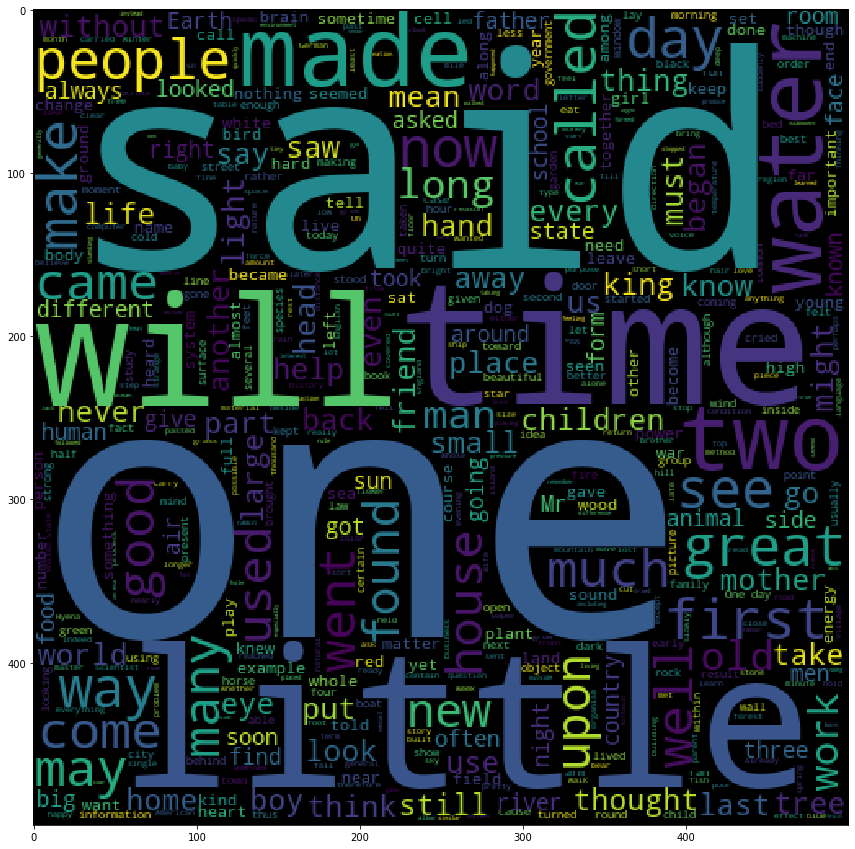

In [ ]:
plot.figure(figsize = (15,15))
commonlit_cloud = WordCloud(max_words = 500 , width = 500 , height = 500 , stopwords = STOPWORDS).generate(" ".join(commonlit_data.excerpt))
plot.imshow(commonlit_cloud , interpolation = 'nearest')

Said,One,little and time are most common words in commonlit data.

## **2.2 Number of characters in  excerpt**

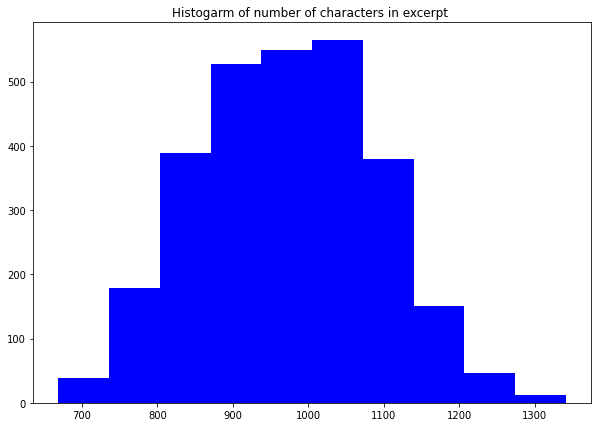

In [ ]:
commonlit_figure,commonlit_axis =plot.subplots(figsize=(10,7))
commonlit_excerpt_char = commonlit_data['excerpt'].str.len()
commonlit_axis.hist(commonlit_excerpt_char,color='blue')
commonlit_axis.set_title('Histogarm of number of characters in excerpt ')
plot.show()

excerpt of 900-1000 characters are most common in commonlit data.

## **2.3 Number of words in excerpt**

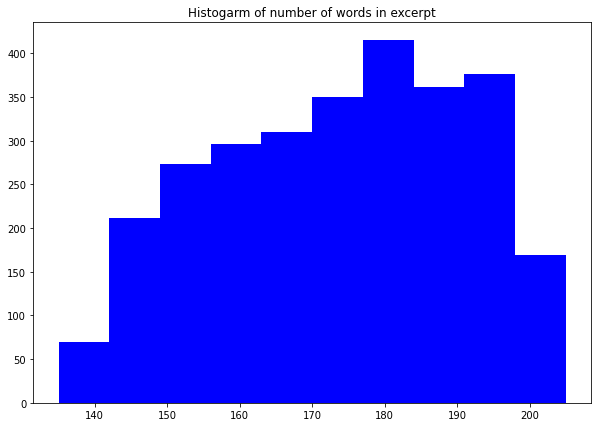

In [ ]:
commonlit_figure,commonlit_axis =plot.subplots(figsize=(10,7))
commonlit_excerpt_words = commonlit_data['excerpt'].str.split().map(lambda x: len(x))
commonlit_axis.hist(commonlit_excerpt_words,color='blue')
commonlit_axis.set_title('Histogarm of number of words in excerpt')
plot.show()

180 words excerpt are most common in commonlit data

## **2.4 Average word length**

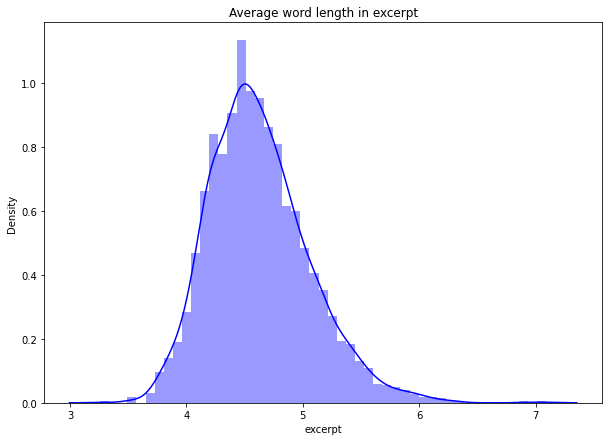

In [ ]:
commonlit_figure,commonlit_axis =plot.subplots(figsize=(10,7))
commonlit_excerpt_word_len = commonlit_data['excerpt'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(commonlit_excerpt_word_len.map(lambda x: np.mean(x)),ax=commonlit_axis,color='blue')
commonlit_axis.set_title('Average word length in excerpt')
plot.show()

4.5 word length is most common for excerpt in commonlit data

### **We are now done with EDA and moving to model building**

# **3.Pre training**

Every NLP models can be used in two ways:
1.   Using orginal model which is trained on original large corpus of text. Using models from https://huggingface.co/models.
2.   We can also train these models using our data(CommonLit). We will be calling such models **Pre Trained**.






Throughout this case study we will be calling original model just by name like **Roberta-Base**.    And, pre-trained models by name like     **Roberta-Base PT (Pre-Trained)**.

Section 3 or below code was used to pre-trained differernt NLP models. Same code was used to pre-trained differernt models with small changes in parameter values.

## **3.1 Loading Data**

In [12]:
pip install nvidia-ml-py3

In [13]:
import nvidia_smi
!nvidia-smi

Sat Feb  5 22:46:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#combining commonlit data and test data for language modelling
pre_training_text = pd.concat([commonlit_data,test_data])
pre_training_text['excerpt'] = pre_training_text['excerpt'].apply(lambda x: x.replace('\n',''))

In [ ]:
pre_training_text.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [ ]:
pre_training_text.tail()

,id,url_legal,license,excerpt,target,standard_error
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...,NaN,NaN
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...,NaN,NaN
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...,NaN,NaN
5,12537fe78,NaN,NaN,"To explain transitivity, let us look first at ...",NaN,NaN
6,965e592c0,https://www.africanstorybook.org/#,CC BY 4.0,Milka and John are playing in the garden. Her ...,NaN,NaN


In [ ]:
pre_training_text['excerpt'][7]

"On the twenty-second of February, 1916, an automobile sped northward along the French battle line that for almost two years had held back the armies of the German emperor, strive as they would to win their way farther into the heart of France. For months the opposing forces had battled to a draw from the North Sea to the boundary of Switzerland, until now, as the day waned—it was almost six o'clock—the hands of time drew closer and closer to the hour that was to mark the opening of the most bitter and destructive battle of the war, up to this time.It was the eve of the battle of Verdun.The occupants of the automobile as it sped northward numbered three. In the front seat, alone at the driver's wheel, a young man bent low. He was garbed in the uniform of a British lieutenant of cavalry. Close inspection would have revealed the fact that the young man was a youth of some eighteen years, fair and good to look upon."

In [ ]:
#creating pre_training_data.txt file
pre_training_data  = '\n'.join(pre_training_text.excerpt.tolist())
with open('pre_training_data.txt','w') as f:
    f.write(pre_training_data)

## **3.2 NLP Models Parameters**

Various NLP models tried for this case study

###  **3.2.1 roberta-base** : https://huggingface.co/roberta-base

In [14]:
MODEL = "roberta-base"
MODEL_TOKENIZER = "roberta-base"
MODEL_BATCH = 16

###  **3.2.2 roberta-large** : https://huggingface.co/roberta-large

In [ ]:
MODEL = "roberta-large"
MODEL_TOKENIZER = "roberta-large"
MODEL_BATCH = 8

###  **3.2.3 deepset/roberta-base-squad2** : https://huggingface.co/deepset/roberta-base-squad2

In [ ]:
MODEL = "deepset/roberta-base-squad2"
MODEL_TOKENIZER = "deepset/roberta-base-squad2"
MODEL_BATCH = 16

###  **3.2.4 deepset/roberta-large-squad2** : https://huggingface.co/deepset/roberta-large-squad2

In [ ]:
MODEL = "deepset/roberta-large-squad2"
MODEL_TOKENIZER = "deepset/roberta-large-squad2"
MODEL_BATCH = 8

###  **3.2.5 microsoft/deberta-base** : https://huggingface.co/microsoft/deberta-base

In [ ]:
MODEL = "microsoft/deberta-base"
MODEL_TOKENIZER = "microsoft/deberta-base"
MODEL_BATCH = 8

###  **3.2.6 microsoft/deberta-large** : https://huggingface.co/microsoft/deberta-large

In [ ]:
MODEL = "microsoft/deberta-large"
MODEL_TOKENIZER = "microsoft/deberta-large"
MODEL_BATCH = 4

###  **3.2.7 microsoft/deberta-v3-large** : https://huggingface.co/microsoft/deberta-v3-large

In [ ]:
MODEL = "microsoft/deberta-v3-large"
MODEL_TOKENIZER = "microsoft/deberta-v3-large"
MODEL_BATCH = 4

###  **3.2.8 google/electra-large-discriminator** : https://huggingface.co/google/electra-large-discriminator

In [ ]:
MODEL = "google/electra-large-discriminator"
MODEL_TOKENIZER = "google/electra-large-discriminator"
MODEL_BATCH = 8

###  **3.2.9 albert-large-v2** : https://huggingface.co/albert-large-v2

In [ ]:
MODEL = "albert-large-v2"
MODEL_TOKENIZER = "albert-large-v2"
MODEL_BATCH = 16

###  **3.2.10 bert-large-uncased** : https://huggingface.co/bert-large-uncased

In [ ]:
MODEL = "bert-large-uncased"
MODEL_TOKENIZER = "bert-large-uncased"
MODEL_BATCH = 8

###  **3.2.11 funnel-transformer/large** : https://huggingface.co/funnel-transformer/large

In [ ]:
MODEL = "funnel-transformer/large"
MODEL_TOKENIZER = "funnel-transformer/large"
MODEL_BATCH = 8

## **3.3 Language Modelling**

We are pre-training **roberta-base** here. To pre-train different NLP models, change values for MODEL, MODEL_TOKENIZER and MODEL_BATCH.

In [ ]:
MODEL = "roberta-base"
MODEL_TOKENIZER = "roberta-base"
MODEL_BATCH = 16

In [ ]:
#create a class of the relevant architecture.
lm_model = AutoModelForMaskedLM.from_pretrained(MODEL)
lm_token = AutoTokenizer.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
#directory to save pre-trained model.
PRE_TRAINING_DIRECTORY = "./pre-" + MODEL
PRE_TRAINING_DIRECTORY_EVAL = "./pre-" + MODEL + "-eval"

In [ ]:
print(PRE_TRAINING_DIRECTORY)
print(PRE_TRAINING_DIRECTORY_EVAL)

./pre-roberta-base
./pre-roberta-base-eval


In [ ]:
#saving tokenizer in directory.
lm_token.save_pretrained(PRE_TRAINING_DIRECTORY)

('./pre-roberta-base/tokenizer_config.json',
 './pre-roberta-base/special_tokens_map.json',
 './pre-roberta-base/vocab.json',
 './pre-roberta-base/merges.txt',
 './pre-roberta-base/added_tokens.json')

In [ ]:
#Masked Language Modelling Parameters.
PRE_TRAINING_BLOCK = 256
PRE_TRAINING_EPOCH = 5
PRE_TRAINING_EVAl_SAVE = 2
PRE_TRAINING_STEPS = 200
PRE_TRAINING_FILE = "pre_training_data.txt"
PRE_TRAINING_PROBABILITY = .15
PRE_TRAINING_REPORT = "none"
PRE_TRAINING_STRATEGY = "steps"
PRE_TRAINING_METRIC = "eval_loss"


In [ ]:
#reads each line separately, tokenizes and truncates the lines to block_size.
lm_train = LineByLineTextDataset(tokenizer = lm_token,file_path = PRE_TRAINING_FILE, block_size = PRE_TRAINING_BLOCK)
lm_eval = LineByLineTextDataset(tokenizer = lm_token,file_path = PRE_TRAINING_FILE, block_size = PRE_TRAINING_BLOCK)

In [ ]:
print(lm_train)
print(lm_eval)

In [ ]:
#Data collators are objects that will form a batch by using a list of dataset elements as input.
lm_input = DataCollatorForLanguageModeling(tokenizer=lm_token, mlm=True, mlm_probability=PRE_TRAINING_PROBABILITY)

In [ ]:
print(lm_input)

DataCollatorForLanguageModeling(tokenizer=PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}), mlm=True, mlm_probability=0.15)


In [ ]:
#access all the points of customization during training
lm_parameters = TrainingArguments(
    output_dir = PRE_TRAINING_DIRECTORY_EVAL, 
    overwrite_output_dir = True,
    num_train_epochs = PRE_TRAINING_EPOCH,
    per_device_train_batch_size = MODEL_BATCH,
    per_device_eval_batch_size = MODEL_BATCH,
    evaluation_strategy= PRE_TRAINING_STRATEGY,
    save_total_limit=PRE_TRAINING_EVAl_SAVE,
    eval_steps = PRE_TRAINING_STEPS,
    metric_for_best_model = PRE_TRAINING_METRIC,
    greater_is_better=False,
    load_best_model_at_end =True,
    prediction_loss_only=True,
    report_to = PRE_TRAINING_REPORT)

In [ ]:
print(lm_parameters)

TrainingArguments(output_dir=./pre-roberta-base-eval, overwrite_output_dir=True, do_train=False, do_eval=None, do_predict=False, evaluation_strategy=IntervalStrategy.STEPS, prediction_loss_only=True, per_device_train_batch_size=16, per_device_eval_batch_size=16, gradient_accumulation_steps=1, eval_accumulation_steps=None, learning_rate=5e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_ratio=0.0, warmup_steps=0, logging_dir=runs/Feb04_13-59-31_3e667b309442, logging_strategy=IntervalStrategy.STEPS, logging_first_step=False, logging_steps=500, save_strategy=IntervalStrategy.STEPS, save_steps=500, save_total_limit=2, no_cuda=False, seed=42, fp16=False, fp16_opt_level=O1, fp16_backend=auto, fp16_full_eval=False, local_rank=-1, tpu_num_cores=None, tpu_metrics_debug=False, debug=False, dataloader_drop_last=False, eval_steps=200, dataloader_num_workers=0, past_index=

In [ ]:
#feature-complete training
language_modelling = Trainer(
    model=lm_model,
    args=lm_parameters,
    data_collator=lm_input,
    train_dataset=lm_train,
    eval_dataset=lm_eval)

In [ ]:
print(language_modelling)

In [ ]:
#training loop
language_modelling.train()
language_modelling.save_model(PRE_TRAINING_DIRECTORY)

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
200,No log,1.444128,31.739100,89.511000
400,No log,1.383117,31.747100,89.488000
600,1.550500,1.340850,31.741700,89.504000
800,1.550500,1.320047,31.739000,89.511000


# **4. Fine Tune NLP Models**

In fine-tuning we take NLP model and train again on downstream task. Here down-stream task is regression. We also use various fine tuning strategies:
1. Concatenate last 4 layers
2. Attention Head
3. Layer-wise Learning Rate Decay (LLRD)
4. Frequent Evaluation

## **4.1 Loading Data**

In [15]:
#To use Pre-Trained Model 
PRE_TRAINED_MODEL = True


In [16]:
#To concatenate Last 4 layers
Concatenate_Last_4_Layers = True

In [17]:
#checking if model is pre-trained
if (PRE_TRAINED_MODEL):
  MODEL = "pre-" + MODEL
  MODEL_TOKENIZER = "pre-" + MODEL_TOKENIZER

In [18]:
print(MODEL)
print(MODEL_TOKENIZER)

pre-roberta-base
pre-roberta-base


In [19]:
#Model Training Parameters
MODEL_KFOLDS = 5
MODEL_EPOCHS = 2
MODEL_LENGTH = 248
MODEL_STEP = [(0.50, 16), (0.49, 8), (0.48, 4), (0.47, 2), (-1., 1)]
MODEL_PAD = "max_length"
MODEL_NORM = 1e-7
MODEL_PROB = 0.0
MODEL_HIDDEN_1 = 1
MODEL_HIDDEN_2 = 512
MODEL_HIDDEN_3 = 768
MODEL_SEED_VALUE = 1000
MODEL_REDUCTION_TRAIN = "mean"
MODEL_REDUCTION_VAL = "sum"
MODEL_WEIGHT_DECAY = .01
MODEL_WEIGHT_DECAY_BIAS = 0.0
MODEL_LR_1 = 2e-5
MODEL_LR_2 = 5e-5
MODEL_LR_3 = 1e-4
MODEL_CPU_WORKERS = 2
MODEL_WARMUP = 50

In [20]:
#dropping target and standard_error with both zero values
commonlit_data.drop(commonlit_data[(commonlit_data.target == 0) & (commonlit_data.standard_error == 0)].index,inplace=True)
commonlit_data.reset_index(drop=True, inplace=True)

In [21]:
MODEL_TOKENIZER

'pre-roberta-base'

In [22]:
model_token = AutoTokenizer.from_pretrained(MODEL_TOKENIZER)

## **4.2 Model Architecture**

Here we are creating model architecture using TorchNeuralNetwork module.
Model architecture will be **model + attention head + regression**.


*   Model: Various Transformers models like roberta-base
*   attention head: This take output from last layer of transformer and passes through first linear layer with tanh activation function.Then it passes through second linear layer followed by softmax function.
*   regression : one linear layer






Transformers typically return **three types of raw output**:

1.   last_hidden_state : output of last layer of transformer.
2.   pooler_output  : first token of sequence.
3.   hidden_states : output of all layers of transformer.



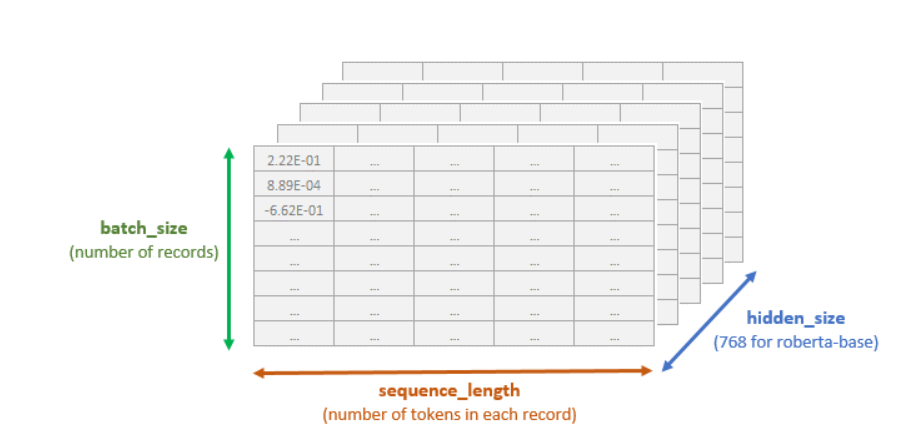

Transformers have different number of layer and hidden size. For roberta-base there are 12 layers and 768 is hidden size.  For roberta large there are 24 layers and 1024 is hidden size.

**Below section of code uses two fine tuning strategies**:

 **1. Concatenate Last 4 layers:** Instead of using only output of last layer of transformer. We will be using output of last 4 layers of transformers.

**2. Attention Head:** Here we pass output of last layer of transformer to Attention Head Network(#Attention_Head) to  get weights. Then we multiply these weigths by output of  last layer of transformer and mean  the resultant tensor across sequence length dimesion to get context vector which will be passed to regression layer. Here aim is to compress tensor(output of last layer of transformer) across the sequence length dimension . To do so we get weigths of different cells across sequence length by Attention Head. We could have just passed output tensor of last layer of transformer to regression layer to get prediction score . But there will be some words in sequence(sentence) which will be influencing prediction score(reading ease) more. Thats why we are first getting weigths of all words of sequence so that we can do weighted average.Then we pass weighted average(context vector) to regression layer.

In [23]:
'''
TorchNeuralNetwork.Module   Base class for all neural network modules.
Here we are creating NLP architecture to get prediction score.
The forward function of this class will be called when we pass input.
For example: return = CommonLit_Architecture(**input) . The forward function will get called to get return.
'''

'\nTorchNeuralNetwork.Module   Base class for all neural network modules.\nHere we are creating NLP architecture to get prediction score.\nThe forward function of this class will be called when we pass input.\nFor example: return = CommonLit_Architecture(**input) . The forward function will get called to get return.\n'

In [24]:
class CommonLit_Architecture(TorchNeuralNetwork.Module): 
    def __init__(self):
        super().__init__()

        #Download configuration from huggingface.co
        commonlit_cfg = AutoConfig.from_pretrained(MODEL)

        #Chaning parameters of configuration file
        commonlit_cfg.update({"output_hidden_states":True, "hidden_dropout_prob": MODEL_PROB,"layer_norm_eps": MODEL_NORM}) 

        #The architecture we want to use can be get from the name or the path of the pretrained model we are supplying to the from_pretrained method.
        #AutoClasses are here to do this job for us so that we can automatically retrieve the relevant model given the name/path to the pretrained weights/config/vocabulary:
        self.model = AutoModel.from_pretrained(MODEL, config=commonlit_cfg) 

        #Attention_Head(2nd Fine Tuning Strategy)     
        self.attn_head = TorchNeuralNetwork.Sequential(            
            TorchNeuralNetwork.Linear(MODEL_HIDDEN_3, MODEL_HIDDEN_2),            
            TorchNeuralNetwork.Tanh(),                       
            TorchNeuralNetwork.Linear(MODEL_HIDDEN_2, MODEL_HIDDEN_1),
            TorchNeuralNetwork.Softmax(dim=MODEL_HIDDEN_1)
        )

        #regression layer
        self.linear_reg = TorchNeuralNetwork.Sequential(                        
            TorchNeuralNetwork.Linear(MODEL_HIDDEN_3, MODEL_HIDDEN_1)                        
        ) 
        
    #forward function
    def forward(self, commonlit_encode, commonlit_attn):

        #output of last layer of transformer
        model_hidden = self.model(input_ids=commonlit_encode,attention_mask=commonlit_attn)  #shape: Batch_Size*Sequence_Length*Hidden_Size     

        if not Concatenate_Last_4_Layers:
          #Use only output of last layer of transformer
          model_hidden_stack_mean = model_hidden.hidden_states[-1]
        else:
          #Concatenate Last 4 layers(1st Fine Tuning Strategy)
          model_hidden_stack = torch.stack([model_hidden.hidden_states[-1],model_hidden.hidden_states[-2],model_hidden.hidden_states[-3],model_hidden.hidden_states[-4]]) 
                                                                                                                #shape: 4*Batch_Size*Sequence_Length*Hidden_Size 
          model_hidden_stack_mean =  torch.mean(model_hidden_stack, 0) #shape:Batch_Size*Sequence_Length*Hidden_Size

        #Getting weigths from Attention_Head Network
        model_hidden_weight = self.attn_head(model_hidden_stack_mean) #shape:*Batch_Size*Sequence_Length*1
                
        # Multiplying weigths(model_hidden_weight) from Attention_Head Network by Output of last layer of network(model_hidden_stack_mean). 
        # model_hidden_weight * model_hidden_stack_mean
        # Then averaging the tensor across sequence Length Dimension.
        # The output(model_hidden_vec) will be passed to Regression Layer to get prediction score.
        model_hidden_vec = torch.sum(model_hidden_weight * model_hidden_stack_mean, dim=1) #shape:*Batch_Size*Hidden_Size     
    
        return self.linear_reg(model_hidden_vec)
    

## **4.3 Model Optimizer**

Here we are implementing **3rd fine tuning strategy:
Layer-wise Learning Rate Decay (LLRD)**

In this we give different learning rate to different layers of transformer model. We are using three different learning rate to corresponding group of layers with initial group of layers lowest and last group of layers highest.

For example roberta-base has 12 layers.Different Learning rate for different layers:  

*   Group 1(Layers 1-4) : 2e-5
*   Group 2 (Layers 5-8) : 5e-5
*   Group 3(Layers 9-12) : 1e-4

We will give Weight Decay of .01 if Model Layer dont have bias as parameter.

Below is Model Parameter Values.

*   MODEL_LAYER_START : This is start of 1st group of layers or 1/3rd of Total layers of Model. For example roberta-base has 12 layers.So 4th layer starts here.
*   MODEL_LAYER_MIDDLE : This is start of 2nd group of layers or 2/3rd of Total layers of Model. For example roberta-base has 12 layers.So 8th layer starts here.
*   MODEL_LAYER_LAST : This is start of 3rd group of layers or 3/3rd of Total layers of Model. For example roberta-base has 12 layers.So 12th layer starts here.
*   MODEL_ATTN_START : This is start of Attention_Head layers.
*   MODEL_REG_START : This is start of Regression layers.








**roberta-base**

In [25]:
MODEL_LAYER_START = 69
MODEL_LAYER_MIDDLE = 133
MODEL_LAYER_LAST = 197
MODEL_ATTN_START = 199
MODEL_REG_START = 203

**roberta-large** 

In [26]:
MODEL_LAYER_START = 133
MODEL_LAYER_MIDDLE = 261
MODEL_LAYER_LAST = 389
MODEL_ATTN_START = 391
MODEL_REG_START = 395

**deepset/roberta-base-squad2**

In [27]:
MODEL_LAYER_START = 69
MODEL_LAYER_MIDDLE = 133
MODEL_LAYER_LAST = 197
MODEL_ATTN_START = 199
MODEL_REG_START = 203

**deepset/roberta-large-squad2** 

In [28]:
MODEL_LAYER_START = 133
MODEL_LAYER_MIDDLE = 261
MODEL_LAYER_LAST = 389
MODEL_ATTN_START = 391
MODEL_REG_START = 395

**microsoft/deberta-base** 

In [29]:
MODEL_LAYER_START = 67
MODEL_LAYER_MIDDLE = 131
MODEL_LAYER_LAST = 195
MODEL_ATTN_START = 196
MODEL_REG_START = 200

**microsoft/deberta-large** 

In [30]:
MODEL_LAYER_START = 131
MODEL_LAYER_MIDDLE = 259
MODEL_LAYER_LAST = 387
MODEL_ATTN_START = 390
MODEL_REG_START = 394

**microsoft/deberta-v3-large** 

In [31]:
MODEL_LAYER_START = 131
MODEL_LAYER_MIDDLE = 259
MODEL_LAYER_LAST = 387
MODEL_ATTN_START = 390
MODEL_REG_START = 394

**google/electra-large-discriminator**

In [32]:
MODEL_LAYER_START = 133
MODEL_LAYER_MIDDLE = 261
MODEL_LAYER_LAST = 389
MODEL_ATTN_START= 389
MODEL_REG_START = 393

**albert-large-v2**

In [33]:
MODEL_LAYER_START = 8
MODEL_LAYER_MIDDLE = 15
MODEL_LAYER_LAST = 23
MODEL_ATTN_START= 25
MODEL_REG_START = 29

**bert-large-uncased** 

In [34]:
MODEL_LAYER_START = 133
MODEL_LAYER_MIDDLE = 261
MODEL_LAYER_LAST = 389
MODEL_ATTN_START= 391
MODEL_REG_START = 395

**funnel-transformer/large**

In [35]:
MODEL_LAYER_START = 163
MODEL_LAYER_MIDDLE = 323
MODEL_LAYER_LAST = 523
MODEL_ATTN_START= 523
MODEL_REG_START = 527

In [37]:
'''
Optimizer Function
'''

'\nOptimizer Function\n'

In [38]:
def commonlit_opt(commonlit_arch):

  #Returns an iterator over module parameters, yielding both the name of the parameter as well as the parameter itself.
  commonlit_param = list(commonlit_arch.named_parameters())  
          
  model_layer_specification = commonlit_param[:MODEL_LAYER_LAST]
  attn_head_specification = commonlit_param[MODEL_ATTN_START:MODEL_REG_START]
  linear_reg_specification = commonlit_param[MODEL_REG_START:]
   
  attn_head_set = [attn_head_specification_val for (_, attn_head_specification_val) in attn_head_specification]      
  linear_reg_set = [linear_reg_specification_val for (_, linear_reg_specification_val) in linear_reg_specification]

  arch_variables = []
  arch_variables.append({"params": attn_head_set})
  arch_variables.append({"params": linear_reg_set})

  #Differernt LR for three different group of Model Layers
  #If Layer has no bias as parameter then weight decay of 0.01
  for model_lyr_no, (model_label, model_lyr_spec) in enumerate(model_layer_specification):
    if "bias" in model_label:
      model_wd = MODEL_WEIGHT_DECAY_BIAS 
    else:
      model_wd = MODEL_WEIGHT_DECAY

    learning_rate = MODEL_LR_1

    if model_lyr_no >= MODEL_LAYER_START:        
      learning_rate = MODEL_LR_2

    if model_lyr_no >= MODEL_LAYER_MIDDLE:
      learning_rate = MODEL_LR_3

    arch_variables.append({"params": model_lyr_spec,"weight_decay": model_wd,"lr": learning_rate})

  commonlit_opt_return = AdamW(arch_variables)

  return commonlit_opt_return

## **4.4 Validation Function**

In [39]:
'''
Validation Function
'''

'\nValidation Function\n'

In [40]:
def commonlit_val(commonlit_arch, commonlit_iterable):

  #Sets the module in evaluation mode
  commonlit_arch.eval() 

  mean_sum_square = 0

  #context-manager that disabled gradient calculation
  with torch.no_grad():
    #enumerating over validation data
    for _,(commonlit_encode, commonlit_attn, commonlit_read_ease) in enumerate(commonlit_iterable):

      commonlit_read_ease = commonlit_read_ease.to(CUDA)  
      commonlit_attn = commonlit_attn.to(CUDA)           
      commonlit_encode = commonlit_encode.to(CUDA)        

      #getting return from CommonLit_Architecture      
      commonlit_return = commonlit_arch(commonlit_encode, commonlit_attn)

      #Flattens input by reshaping it into a one-dimensional tensor.                        
      commonlit_flatten = commonlit_return.flatten()

      #measures the mean squared error between each element in the input and target.
      mean_sum_square += TorchNeuralNetwork.MSELoss(reduction=MODEL_REDUCTION_VAL)(commonlit_flatten, commonlit_read_ease).item()

  #getting length of validation dataset          
  iter_len = len(commonlit_iterable.dataset)

  #getting return of commonlit_val function
  commonlit_val_return = mean_sum_square / iter_len 
  
  return commonlit_val_return

## **4.5 Setting Random Values**

In [41]:
'''
Code to set all the random values used in this case study
'''

'\nCode to set all the random values used in this case study\n'

In [42]:
def model_rset(rvalue):

  #initialize the random number generator
  random.seed(rvalue)

  #random numbers predictable
  np.random.seed(rvalue)

  #setting os environment value
  os.environ["PYTHONHASHSEED"] = str(rvalue)

  #sets the seed for generating random numbers
  torch.manual_seed(rvalue)

  #sets the seed for generating random numbers for the current GPU
  torch.cuda.manual_seed(rvalue)

  #sets the seed for generating random numbers on all GPUs
  torch.cuda.manual_seed_all(rvalue)

  #setting cuda backend value
  torch.backends.cudnn.deterministic = True

## **4.6 PyTorch DataSet Class**

In [43]:
'''
PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow us to use your own data.
Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.
A custom Dataset class has three functions: __init__, __len__, and __getitem__.
'''

'\nPyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow us to use your own data.\nDataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.\nA custom Dataset class has three functions: __init__, __len__, and __getitem__.\n'

In [44]:
class CommonLit_Item(Dataset):
  #run once when instantiating the Dataset object
  def __init__(self, data, io=False):
    super().__init__()

    self.io = io
    if not self.io:
      self.read_ease = torch.tensor(data.target.values, dtype=torch.float32) 

    self.excerpt = data.excerpt.tolist()
    self.ec = model_token.batch_encode_plus(self.excerpt,padding = MODEL_PAD,max_length = MODEL_LENGTH,truncation = True,return_attention_mask=True)

    self.item_data = data        

  #loads and returns a sample from the dataset at the given index.                                   
  def __getitem__(self, index): 
    commonlit_attn = torch.tensor(self.ec['attention_mask'][index])       
    commonlit_encode = torch.tensor(self.ec['input_ids'][index])
        
    if not self.io:
      commonlit_read_ease = self.read_ease[index]
      return (commonlit_encode, commonlit_attn, commonlit_read_ease)       
    else:
      return (commonlit_encode, commonlit_attn)   

  #returns the number of samples in our dataset.  
  def __len__(self):
    return len(self.item_data)  

## **4.7 CommonLit Architecture Main function and Frequent Evaluation**

We will go through all batches of data,get reading ease scores,back-propagate,optimizer and scheduler will update respective parameters.

Below function also implements **4th fine tuning strategy:Frequent Evaluation**

In Frequent Evaluation we check validation scores after passage of certain number of batches. We call passage of one batch of train data as one step.After certain number of steps we check for validation score. We also keep on changing steps based on validation score.

In this case study we are following this schedule: **MODEL_STEP** = [(0.50, 16), (0.49, 8), (0.48, 4), (0.47, 2), (-1., 1)]. The first value of every tuple is validation score(vs) and second value is step size.

Above means, if validation score(VS) is above .5( first value in array). Number of steps is 16.

If .49<VS<.5 ,then number of steps is 8. If .48<VS<.49 then number of steps is 4. And so on....

If new validation score is less than previous validation score we save the model. Important thing is we check for validation score after certain number of steps . Or value based in MODEL_STEP array. The reasoning here is that we have all the time to train the model and aim here is to get best possible score.So we can increase training time significantly in return of getting best possible predictions.

In [45]:
'''
Function to input CommonLit Architecture Class and to implement frequent evaluation.
'''

'\nFunction to input CommonLit Architecture Class and to implement frequent evaluation.\n'

In [46]:
def commonlit_architecture_main(commonlit_arch, arch_dir, cl_tr_iterable, cl_eval_iterable,commonlit_opt_adamw, commonlit_sch):   
    
  batch_interval = MODEL_STEP[0][1] 
  batch_checker = 0
  previous_period = 0
  top_epoch = 0
  top_eval_score = 1
  commonlit_epoch = 0

  while(commonlit_epoch <= MODEL_EPOCHS):   
    commonlit_eval = None    

    #we are iterating through our dataset
    for commonlit_bn, (commonlit_encode, commonlit_attn, commonlit_read_ease) in enumerate(cl_tr_iterable):

      commonlit_read_ease = commonlit_read_ease.to(CUDA) 
      commonlit_attn = commonlit_attn.to(CUDA)
      commonlit_encode = commonlit_encode.to(CUDA)

      # zero the parameter gradients                                     
      commonlit_opt_adamw.zero_grad()

      # sets the modules in the network in training mode.
      commonlit_arch.train()

      # return from CommonLit Architecture Class
      commonlit_return = commonlit_arch(commonlit_encode, commonlit_attn) 

      # Flattens input by reshaping it into a one-dimensional tensor.  
      commonlit_flatten = commonlit_return.flatten()   

      #measures the mean squared error between each element in the input and target.                                    
      commonlit_score = TorchNeuralNetwork.MSELoss(reduction=MODEL_REDUCTION_TRAIN)(commonlit_flatten, commonlit_read_ease)   

      # computes the gradient of current tensor       
      commonlit_score.backward()

      #parameter update
      commonlit_opt_adamw.step()

      #update learning rate
      commonlit_sch.step()

      # following code implements Frequent Evaluation(4th fine tuning strategy)      
      if batch_checker >= previous_period + batch_interval:

        batch_forward = batch_checker - previous_period

        #getting validation score
        val_mse_score = commonlit_val(commonlit_arch, cl_eval_iterable)
        commonlit_eval = SquareRoot(val_mse_score)                                  

        # checking for values in MODEL_STEP
        for model_step_score, model_step_range in MODEL_STEP:
          if commonlit_eval >= model_step_score:
            batch_interval = model_step_range
            break  

        print("\nCurrent_Period:{0}".format(batch_forward))
        print("Epoch:{0}   Batch_Passed:{1}   Score:{2:0.3f}".format(commonlit_epoch,commonlit_bn,commonlit_eval))
        previous_period = batch_checker    

        # if current validation score is less than best validation score. We save the model
        if commonlit_eval >= top_eval_score:
          print("Current_Best_Score:{0:0.3f} from Epoch:{1}".format(top_eval_score,top_epoch))          
        else:       
          top_epoch = commonlit_epoch 
          top_eval_score = commonlit_eval
          print("New_Best_Score:{0:0.3f}".format(top_eval_score,))                        
          torch.save(commonlit_arch.state_dict(), arch_dir)

      batch_checker += 1
    commonlit_epoch = commonlit_epoch + 1    

  return top_eval_score

In [47]:
# Python garbage collector
gc.collect()

MODEL_RANDOM = MODEL_SEED_VALUE
model_eval_score = []

# Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds
model_kf = KFold(n_splits=MODEL_KFOLDS, random_state=MODEL_RANDOM, shuffle=True)

#going through each of fold
for model_kf_value, (model_tr_rows, model_eval_rows) in enumerate(model_kf.split(commonlit_data)): 

    model_kf_value_one = model_kf_value + 1  
    model_ran_value = MODEL_RANDOM + model_kf_value 
    arch_dir = f"model_{model_kf_value_one}.pth"
    model_rset(model_ran_value)

    print("\nKFold {0}".format(model_kf_value_one))

    cl_train = commonlit_data.loc[model_tr_rows]

    #creating datasets
    cl_tr_item = CommonLit_Item(cl_train)

    cl_eval = commonlit_data.loc[model_eval_rows] 

    #creating datasets   
    cl_eval_item = CommonLit_Item(cl_eval)    

    #creating iterable datasets    
    cl_tr_iterable = DataLoader(cl_tr_item, batch_size=MODEL_BATCH,drop_last=True, shuffle=True, num_workers=MODEL_CPU_WORKERS)    
    cl_eval_iterable = DataLoader(cl_eval_item, batch_size=MODEL_BATCH,drop_last=False, shuffle=False, num_workers=MODEL_CPU_WORKERS)    
        
    #setting random values
    model_rset(model_ran_value)    
    
    #initializing commonlit architecture and move to CUDA device
    commonlit_arch = CommonLit_Architecture().to(CUDA)

    #AdamW optimizer
    commonlit_opt_adamw = commonlit_opt(commonlit_arch)   

    no_tr_steps = MODEL_EPOCHS * len(cl_tr_iterable) 

    #Create a schedule with a learning rate that decreases following the values of the cosine function 
    #between the initial lr set in the optimizer to 0, 
    #after a warmup period during which it increases linearly between 0 and the initial lr set in the optimizer.                    
    commonlit_sch = get_cosine_schedule_with_warmup(commonlit_opt_adamw,num_training_steps=no_tr_steps,num_warmup_steps=MODEL_WARMUP)    
    
    #return score from main commonlit architecture function
    fine_tune_score =commonlit_architecture_main(commonlit_arch, arch_dir, cl_tr_iterable,cl_eval_iterable, commonlit_opt_adamw,commonlit_sch) 
    model_eval_score.append(fine_tune_score)

    del commonlit_arch
    gc.collect()
    
    print("\nScore:{0}".format(fine_tune_score))   


KFold 1


Some weights of RobertaModel were not initialized from the model checkpoint at pre-roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Current_Period:16
Epoch:0   Batch_Passed:16   Score:1.054
Current_Best_Score:1.000 from Epoch:0

Current_Period:16
Epoch:0   Batch_Passed:32   Score:0.792
New_Best_Score:0.792

Current_Period:16
Epoch:0   Batch_Passed:48   Score:0.655
New_Best_Score:0.655

Current_Period:16
Epoch:0   Batch_Passed:64   Score:0.613
New_Best_Score:0.613

Current_Period:16
Epoch:0   Batch_Passed:80   Score:0.576
New_Best_Score:0.576

Current_Period:16
Epoch:0   Batch_Passed:96   Score:0.619
Current_Best_Score:0.576 from Epoch:0

Current_Period:16
Epoch:0   Batch_Passed:112   Score:0.526
New_Best_Score:0.526

Current_Period:16
Epoch:0   Batch_Passed:128   Score:0.539
Current_Best_Score:0.526 from Epoch:0

Current_Period:16
Epoch:1   Batch_Passed:3   Score:0.582
Current_Best_Score:0.526 from Epoch:0

Current_Period:16
Epoch:1   Batch_Passed:19   Score:0.551
Current_Best_Score:0.526 from Epoch:0

Current_Period:16
Epoch:1   Batch_Passed:35   Score:0.497
New_Best_Score:0.497

Current_Period:8
Epoch:1   Batch_

Some weights of RobertaModel were not initialized from the model checkpoint at pre-roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Current_Period:16
Epoch:0   Batch_Passed:16   Score:1.045
Current_Best_Score:1.000 from Epoch:0

Current_Period:16
Epoch:0   Batch_Passed:32   Score:0.778
New_Best_Score:0.778

Current_Period:16
Epoch:0   Batch_Passed:48   Score:0.652
New_Best_Score:0.652

Current_Period:16
Epoch:0   Batch_Passed:64   Score:0.613
New_Best_Score:0.613

Current_Period:16
Epoch:0   Batch_Passed:80   Score:0.630
Current_Best_Score:0.613 from Epoch:0

Current_Period:16
Epoch:0   Batch_Passed:96   Score:0.545
New_Best_Score:0.545

Current_Period:16
Epoch:0   Batch_Passed:112   Score:0.672
Current_Best_Score:0.545 from Epoch:0

Current_Period:16
Epoch:0   Batch_Passed:128   Score:0.534
New_Best_Score:0.534

Current_Period:16
Epoch:1   Batch_Passed:3   Score:0.503
New_Best_Score:0.503

Current_Period:16
Epoch:1   Batch_Passed:19   Score:0.561
Current_Best_Score:0.503 from Epoch:1

Current_Period:16
Epoch:1   Batch_Passed:35   Score:0.516
Current_Best_Score:0.503 from Epoch:1

Current_Period:16
Epoch:1   Batch

Some weights of RobertaModel were not initialized from the model checkpoint at pre-roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Current_Period:16
Epoch:0   Batch_Passed:16   Score:1.089
Current_Best_Score:1.000 from Epoch:0

Current_Period:16
Epoch:0   Batch_Passed:32   Score:0.695
New_Best_Score:0.695

Current_Period:16
Epoch:0   Batch_Passed:48   Score:0.587
New_Best_Score:0.587

Current_Period:16
Epoch:0   Batch_Passed:64   Score:0.653
Current_Best_Score:0.587 from Epoch:0

Current_Period:16
Epoch:0   Batch_Passed:96   Score:0.555
New_Best_Score:0.555

Current_Period:16
Epoch:0   Batch_Passed:112   Score:0.559
Current_Best_Score:0.555 from Epoch:0

Current_Period:16
Epoch:0   Batch_Passed:128   Score:0.549
New_Best_Score:0.549

Current_Period:16
Epoch:1   Batch_Passed:3   Score:0.562
Current_Best_Score:0.549 from Epoch:0

Current_Period:16
Epoch:1   Batch_Passed:19   Score:0.508
New_Best_Score:0.508

Current_Period:16
Epoch:1   Batch_Passed:35   Score:0.492
New_Best_Score:0.492

Current_Period:8
Epoch:1   Batch_Passed:43   Score:0.507
Current_Best_Score:0.492 from Epoch:1

Current_Period:16
Epoch:1   Batch_

Some weights of RobertaModel were not initialized from the model checkpoint at pre-roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Current_Period:16
Epoch:0   Batch_Passed:16   Score:1.184
Current_Best_Score:1.000 from Epoch:0

Current_Period:16
Epoch:0   Batch_Passed:32   Score:0.728
New_Best_Score:0.728

Current_Period:16
Epoch:0   Batch_Passed:48   Score:0.648
New_Best_Score:0.648

Current_Period:16
Epoch:0   Batch_Passed:64   Score:0.601
New_Best_Score:0.601

Current_Period:16
Epoch:0   Batch_Passed:80   Score:0.568
New_Best_Score:0.568

Current_Period:16
Epoch:0   Batch_Passed:96   Score:0.549
New_Best_Score:0.549

Current_Period:16
Epoch:0   Batch_Passed:112   Score:0.553
Current_Best_Score:0.549 from Epoch:0

Current_Period:16
Epoch:0   Batch_Passed:128   Score:0.542
New_Best_Score:0.542

Current_Period:16
Epoch:1   Batch_Passed:3   Score:0.514
New_Best_Score:0.514

Current_Period:16
Epoch:1   Batch_Passed:19   Score:0.525
Current_Best_Score:0.514 from Epoch:1

Current_Period:16
Epoch:1   Batch_Passed:35   Score:0.508
New_Best_Score:0.508

Current_Period:16
Epoch:1   Batch_Passed:51   Score:0.509
Current_B

Some weights of RobertaModel were not initialized from the model checkpoint at pre-roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Current_Period:16
Epoch:0   Batch_Passed:16   Score:1.009
Current_Best_Score:1.000 from Epoch:0

Current_Period:16
Epoch:0   Batch_Passed:32   Score:0.745
New_Best_Score:0.745

Current_Period:16
Epoch:0   Batch_Passed:48   Score:0.650
New_Best_Score:0.650

Current_Period:16
Epoch:0   Batch_Passed:64   Score:0.599
New_Best_Score:0.599

Current_Period:16
Epoch:0   Batch_Passed:80   Score:0.656
Current_Best_Score:0.599 from Epoch:0

Current_Period:16
Epoch:0   Batch_Passed:96   Score:0.538
New_Best_Score:0.538

Current_Period:16
Epoch:0   Batch_Passed:112   Score:0.555
Current_Best_Score:0.538 from Epoch:0

Current_Period:16
Epoch:0   Batch_Passed:128   Score:0.532
New_Best_Score:0.532

Current_Period:16
Epoch:1   Batch_Passed:3   Score:0.554
Current_Best_Score:0.532 from Epoch:0

Current_Period:16
Epoch:1   Batch_Passed:19   Score:0.518
New_Best_Score:0.518

Current_Period:16
Epoch:1   Batch_Passed:35   Score:0.538
Current_Best_Score:0.518 from Epoch:1

Current_Period:16
Epoch:1   Batch

In [49]:
model_score_avg = np.array(model_eval_score).mean()
print("Score Average:{0:0.3f}".format(model_score_avg))

Score Average:0.480


## **4.8 Model Prediction**

In [50]:
'''
commonlist test function
'''

'\ncommonlist test function\n'

In [51]:
def commonlit_test(commonlit_arch, commonlit_iterable):

  #sets model in evaluation mode
  commonlit_arch.eval()

  commonlit_iter_len = len(commonlit_iterable.dataset)
  commonlit_pred = np.zeros(commonlit_iter_len)    
  commonlit_row = 0

  #context-manager that disabled gradient calculation  
  with torch.no_grad():

    #enumerating over test data
    for _, (commonlit_encode, commonlit_attn) in enumerate(commonlit_iterable):
      commonlit_attn = commonlit_attn.to(CUDA)
      commonlit_encode = commonlit_encode.to(CUDA)        

      #getting return from commonlit architecture                  
      commonlit_return = commonlit_arch(commonlit_encode, commonlit_attn)                        

      # Flattens input by reshaping it into a one-dimensional tensor. 
      commonlit_flatten = commonlit_return.flatten()
      commonlit_pred[commonlit_row : commonlit_row + commonlit_return.shape[0]] = commonlit_flatten.to(CPU)
      commonlit_row = commonlit_return.shape[0] + commonlit_row

  return commonlit_pred

In [53]:
commonlit_result = np.zeros((len(model_eval_score), len(test_data)))

#creating datasets
commonlit_item_pred = CommonLit_Item(test_data, io=True)

#creating iterable datasets
commonlit_iterable_pred = DataLoader(commonlit_item_pred, batch_size=MODEL_BATCH,drop_last=False, shuffle=False, num_workers=MODEL_CPU_WORKERS)

#going through each of saved models
for arch_save_model in range(len(model_eval_score)):   
    arch_save_model_one = arch_save_model + 1          
    arch_dir = f"model_{arch_save_model_one}.pth"
    print("Architecture Save Model Path {0}".format(arch_dir))

    #initialize commonlit architecture                    
    commonlit_arch = CommonLit_Architecture()

    #Loads an object saved with torch.save() from a file.
    commonlit_load_dir = torch.load(arch_dir)

    #Loads a model’s parameter dictionary
    commonlit_arch.load_state_dict(commonlit_load_dir) 

    #Sending to CUDA Device   
    commonlit_arch.to(CUDA)
    
    commonlit_result[arch_save_model] = commonlit_test(commonlit_arch, commonlit_iterable_pred)
    
    del commonlit_arch
    gc.collect()

Architecture Save Model Path model_1.pth


Some weights of RobertaModel were not initialized from the model checkpoint at pre-roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Architecture Save Model Path model_2.pth


Some weights of RobertaModel were not initialized from the model checkpoint at pre-roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Architecture Save Model Path model_3.pth


Some weights of RobertaModel were not initialized from the model checkpoint at pre-roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Architecture Save Model Path model_4.pth


Some weights of RobertaModel were not initialized from the model checkpoint at pre-roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Architecture Save Model Path model_5.pth


Some weights of RobertaModel were not initialized from the model checkpoint at pre-roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
#Mean of all predictions across models
nlp_arch_pred = commonlit_result.mean(axis=0)

In [55]:
#Saving the submission file
submission['target'] = nlp_arch_pred
submission.to_csv('submission.csv', index=False)
submission

,id,target
0,c0f722661,-0.497509
1,f0953f0a5,-0.545287
2,0df072751,-0.373235
3,04caf4e0c,-2.501297
4,0e63f8bea,-1.705751
5,12537fe78,-1.388573
6,965e592c0,0.209803


## **4.9 Results**

Below table contains all the models that were tested.

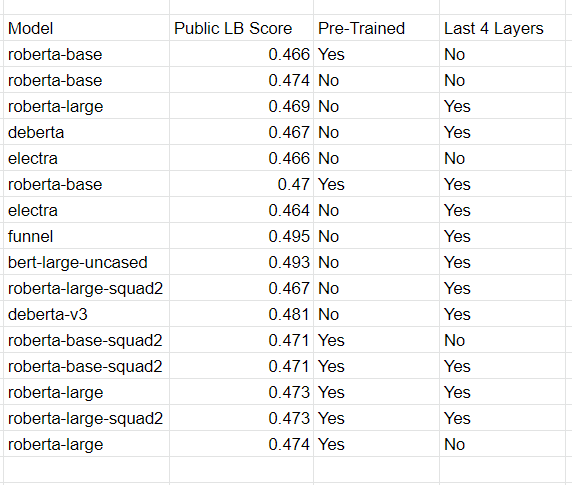

The final ensemble consists of :


*   roberta-base-squad2  PT and 4_Layers
*   roberta-large-squad2  PT and 4_Layers
*   deberta-large  No_PT  and 4_Layers
*   electra  No_PT and No_4_Layers



**Final ensemble got score of .456 on private LB which is top 50 or top 1 percentage.**